In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob


from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

In [2]:
ds = xr.open_dataset('ERA5-LAND.nc')
ds

getfattr: /home/jovyan/EAEE4000_ML_EnvEng/Tutorials/Final: No such file or directory
getfattr: Project_Runoff: No such file or directory
getfattr: Extremes/ERA5-LAND.nc: No such file or directory


<xarray.Dataset> Size: 37GB
Dimensions:     (valid_time: 360, latitude: 1801, longitude: 3600)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 1995-01-01 ... 2024-12-01
  * latitude    (latitude) float64 14kB 90.0 89.9 89.8 ... -89.8 -89.9 -90.0
  * longitude   (longitude) float64 29kB 0.0 0.1 0.2 0.3 ... 359.7 359.8 359.9
    number      int64 8B ...
    expver      (valid_time) <U4 6kB ...
Data variables:
    swvl1       (valid_time, latitude, longitude) float32 9GB ...
    evaow       (valid_time, latitude, longitude) float32 9GB ...
    ro          (valid_time, latitude, longitude) float32 9GB ...
    tp          (valid_time, latitude, longitude) float32 9GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-11-20T04:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
#predictors
ds_tp = ds.tp.coarsen(latitude=20, longitude=20, boundary='trim').mean()
ds_evaow = ds.evaow.coarsen(latitude=20, longitude=20, boundary='trim').mean()
ds_swvl1 = ds.swvl1.coarsen(latitude=20, longitude=20, boundary='trim').mean()
#predictand
ds_ro = ds.ro.coarsen(latitude=20, longitude=20, boundary='trim').mean()
ds_ro

/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)
/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)
/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)
/srv/conda/envs/notebook/lib/python3.12/site-packages/numbagg/decorators.py:245: RuntimeWarning: invalid value encountered in nanmean
  return self.gufunc(target=self.target)(*arrays, axis=-1)


<xarray.DataArray 'ro' (valid_time: 360, latitude: 90, longitude: 180)> Size: 23MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]],
      shape=(360, 90, 180), dtype=float32)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 1995-01-01 ... 2024-12-01
  * latitude    (latitude) float64 720B 89.05 87.05 85.05 ... -86.95 -88.95
  * longitude   (longitude) float64 1kB 0.95 2.95 4.95 ... 355.0 357.0 359.0
    number      int64 8B ...
    expver      (valid_time) <U4 6kB ...
Attributes: (12/31)
    GRIB_paramId:                             205
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      6483600
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_gridType:                            regular_ll
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:                                Runoff
    units:                                    m
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [4]:
#predictors
tp = ds.tp.sel(latitude=slice(50,23,10),longitude=slice(230,300,10))
ep = ds.evaow.sel(latitude=slice(50,23,10),longitude=slice(230,300,10))
sm = ds.swvl1.sel(latitude=slice(50,23,10),longitude=slice(230,300,10))
#predictand
ro = ds.ro.sel(latitude=slice(50,23,10),longitude=slice(230,300,10))
ro

<xarray.DataArray 'ro' (valid_time: 360, latitude: 27, longitude: 70)> Size: 3MB
[680400 values with dtype=float32]
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 1995-01-01 ... 2024-12-01
  * latitude    (latitude) float64 216B 49.9 48.9 47.9 46.9 ... 25.9 24.9 23.9
  * longitude   (longitude) float64 560B 230.1 231.1 232.1 ... 297.1 298.1 299.1
    number      int64 8B ...
    expver      (valid_time) <U4 6kB ...
Attributes: (12/31)
    GRIB_paramId:                             205
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      6483600
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_gridType:                            regular_ll
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               m
    long_name:                                Runoff
    units:                                    m
    standard_name:                            unknown
    GRIB_surface:                             0.0

In [5]:
time=ro.valid_time
lat=ro.latitude
lon=ro.longitude

In [6]:
pred = xr.Dataset(
        {
            'tp': tp,
            'ep': ep,
            'sm': sm
        },
        coords={
            'time': time,
            'latitude': lat,
            'longitude': lon,
        }
    )
pred

<xarray.Dataset> Size: 8MB
Dimensions:     (valid_time: 360, latitude: 27, longitude: 70)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 3kB 1995-01-01 ... 2024-12-01
  * latitude    (latitude) float64 216B 49.9 48.9 47.9 46.9 ... 25.9 24.9 23.9
  * longitude   (longitude) float64 560B 230.1 231.1 232.1 ... 297.1 298.1 299.1
    number      int64 8B 0
    expver      (valid_time) <U4 6kB ...
    time        (valid_time) datetime64[ns] 3kB 1995-01-01 ... 2024-12-01
Data variables:
    tp          (valid_time, latitude, longitude) float32 3MB ...
    ep          (valid_time, latitude, longitude) float32 3MB ...
    sm          (valid_time, latitude, longitude) float32 3MB ...

In [7]:
X_train_xr = pred.sel(valid_time=slice('1995-01-01T00:00:00.000000000','2018-12-01T00:00:00.000000000'))
X_test_xr = pred.sel(valid_time=slice('2019-01-01T00:00:00.000000000','2024-12-01T00:00:00.000000000'))
y_train_xr = ro.sel(valid_time=slice('1995-01-01T00:00:00.000000000','2018-12-01T00:00:00.000000000'))
y_test_xr = ro.sel(valid_time=slice('2019-01-01T00:00:00.000000000','2024-12-01T00:00:00.000000000'))

In [8]:
X_train_xr

<xarray.Dataset> Size: 7MB
Dimensions:     (valid_time: 288, latitude: 27, longitude: 70)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2kB 1995-01-01 ... 2018-12-01
  * latitude    (latitude) float64 216B 49.9 48.9 47.9 46.9 ... 25.9 24.9 23.9
  * longitude   (longitude) float64 560B 230.1 231.1 232.1 ... 297.1 298.1 299.1
    number      int64 8B 0
    expver      (valid_time) <U4 5kB ...
    time        (valid_time) datetime64[ns] 2kB 1995-01-01 ... 2018-12-01
Data variables:
    tp          (valid_time, latitude, longitude) float32 2MB ...
    ep          (valid_time, latitude, longitude) float32 2MB ...
    sm          (valid_time, latitude, longitude) float32 2MB ...

In [9]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def standardize_dataarray(da):
    """standardize DataArray"""
    mean = da.mean()
    std = da.std()
    return (da - mean) / std

X_train_xr_norm = xr.Dataset()
for var in X_train_xr.data_vars:
    X_train_xr_norm[var] = standardize_dataarray(X_train_xr[var])

print(X_train_xr_norm)

# validation
print("n\check:")
for var in X_train_xr_norm.data_vars:
    print(f"{var}: mean={X_train_xr_norm[var].mean().values:.6f}, "
          f"std={X_train_xr_norm[var].std().values:.6f}")

<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_88/2459613804.py:19: SyntaxWarning: invalid escape sequence '\c'
  print("n\check:")


<xarray.Dataset> Size: 7MB
Dimensions:     (valid_time: 288, latitude: 27, longitude: 70)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2kB 1995-01-01 ... 2018-12-01
  * latitude    (latitude) float64 216B 49.9 48.9 47.9 46.9 ... 25.9 24.9 23.9
  * longitude   (longitude) float64 560B 230.1 231.1 232.1 ... 297.1 298.1 299.1
    number      int64 8B 0
    expver      (valid_time) <U4 5kB ...
    time        (valid_time) datetime64[ns] 2kB 1995-01-01 ... 2018-12-01
Data variables:
    tp          (valid_time, latitude, longitude) float32 2MB nan nan ... nan
    ep          (valid_time, latitude, longitude) float32 2MB nan nan ... nan
    sm          (valid_time, latitude, longitude) float32 2MB nan nan ... nan
n\check:
tp: mean=-0.000000, std=1.000000
ep: mean=-0.000000, std=1.000000
sm: mean=0.000000, std=1.000000


In [10]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

def standardize_dataarray(da):
    """标准化单个DataArray"""
    mean = da.mean()
    std = da.std()
    return (da - mean) / std

X_test_xr_norm = xr.Dataset()
for var in X_test_xr.data_vars:
    X_test_xr_norm[var] = standardize_dataarray(X_test_xr[var])

print(X_train_xr_norm)

print("n\check:")
for var in X_test_xr_norm.data_vars:
    print(f"{var}: mean={X_test_xr_norm[var].mean().values:.6f}, "
          f"std={X_test_xr_norm[var].std().values:.6f}")

<>:18: SyntaxWarning: invalid escape sequence '\c'
<>:18: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_88/1663002124.py:18: SyntaxWarning: invalid escape sequence '\c'
  print("n\check:")


<xarray.Dataset> Size: 7MB
Dimensions:     (valid_time: 288, latitude: 27, longitude: 70)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2kB 1995-01-01 ... 2018-12-01
  * latitude    (latitude) float64 216B 49.9 48.9 47.9 46.9 ... 25.9 24.9 23.9
  * longitude   (longitude) float64 560B 230.1 231.1 232.1 ... 297.1 298.1 299.1
    number      int64 8B 0
    expver      (valid_time) <U4 5kB ...
    time        (valid_time) datetime64[ns] 2kB 1995-01-01 ... 2018-12-01
Data variables:
    tp          (valid_time, latitude, longitude) float32 2MB nan nan ... nan
    ep          (valid_time, latitude, longitude) float32 2MB nan nan ... nan
    sm          (valid_time, latitude, longitude) float32 2MB nan nan ... nan
n\check:
tp: mean=0.000000, std=1.000000
ep: mean=0.000000, std=1.000000
sm: mean=-0.000000, std=1.000000


In [11]:
def create_multiindex_dataframe(dataset):
    """
    MultiIndex _DataFrame
    return:
    DataFrame with MultiIndex (valid_time, lat, lon) and columns: tp, ep, sm
    """
    times = X_train_xr_norm['valid_time'].values
    lats = X_train_xr_norm['latitude'].values
    lons = X_train_xr_norm['longitude'].values
    
    # MultiIndex
    index_tuples = []
    for t in times:
        for lat in lats:
            for lon in lons:
                index_tuples.append((t, lat, lon))
    
    index = pd.MultiIndex.from_tuples(
        index_tuples, 
        names=['valid_time', 'latitude', 'longitude']
    )
    
    tp_flat = X_train_xr_norm['tp'].values.ravel()
    ep_flat = X_train_xr_norm['ep'].values.ravel()
    sm_flat = X_train_xr_norm['sm'].values.ravel()
    
    df = pd.DataFrame({
        'tp': tp_flat,
        'ep': ep_flat,
        'sm': sm_flat
    }, index=index)
    
    return df

In [12]:
train = create_multiindex_dataframe(X_train_xr_norm)
X_train_df = train

In [13]:
print(X_train_df.shape)
X_train_df

(544320, 3)


tp        ep        sm
valid_time latitude longitude                              
1995-01-01 49.9     230.1           NaN       NaN       NaN
                    231.1           NaN       NaN       NaN
                    232.1           NaN       NaN       NaN
                    233.1      4.468683  0.680488  0.516710
                    234.1      3.450342  0.940018 -0.177964
...                                 ...       ...       ...
2018-12-01 23.9     295.1           NaN       NaN       NaN
                    296.1           NaN       NaN       NaN
                    297.1           NaN       NaN       NaN
                    298.1           NaN       NaN       NaN
                    299.1           NaN       NaN       NaN

[544320 rows x 3 columns]

In [14]:
X_train = X_train_df.to_numpy()
X_train.shape

(544320, 3)

In [15]:
def create_multiindex_dataframe(dataset):
    """
    MultiIndex _DataFrame
    return:
    DataFrame with MultiIndex (valid_time, lat, lon) and columns: tp, ep, sm
    """
    times = X_test_xr_norm['valid_time'].values
    lats = X_test_xr_norm['latitude'].values
    lons = X_test_xr_norm['longitude'].values
    
    # MultiIndex
    index_tuples = []
    for t in times:
        for lat in lats:
            for lon in lons:
                index_tuples.append((t, lat, lon))
    
    index = pd.MultiIndex.from_tuples(
        index_tuples, 
        names=['valid_time', 'latitude', 'longitude']
    )
    
    tp_flat = X_test_xr_norm['tp'].values.ravel()
    ep_flat = X_test_xr_norm['ep'].values.ravel()
    sm_flat = X_test_xr_norm['sm'].values.ravel()
    
    df = pd.DataFrame({
        'tp': tp_flat,
        'ep': ep_flat,
        'sm': sm_flat
    }, index=index)
    
    return df

In [16]:
test = create_multiindex_dataframe(X_test_xr_norm)
X_test_df = test

In [17]:
print(X_test_df.shape)
X_test_df

(136080, 3)


tp        ep        sm
valid_time latitude longitude                              
2019-01-01 49.9     230.1           NaN       NaN       NaN
                    231.1           NaN       NaN       NaN
                    232.1           NaN       NaN       NaN
                    233.1      7.663169  0.546307  0.669338
                    234.1      4.819474  0.867580  0.099121
...                                 ...       ...       ...
2024-12-01 23.9     295.1           NaN       NaN       NaN
                    296.1           NaN       NaN       NaN
                    297.1           NaN       NaN       NaN
                    298.1           NaN       NaN       NaN
                    299.1           NaN       NaN       NaN

[136080 rows x 3 columns]

In [18]:
X_test = X_test_df.to_numpy()
X_test.shape

(136080, 3)

In [19]:
y_train_df = y_train_xr.stack({"stacked": ("valid_time", "latitude", "longitude")})
y_train_df = pd.DataFrame(y_train_df.to_pandas())
y_test_df = y_test_xr.stack({"stacked": ("valid_time", "latitude", "longitude")})
y_test_df = pd.DataFrame(y_test_df.to_pandas())

In [20]:
print(y_train_df.shape)
y_train_df

(544320, 1)


ro
valid_time latitude longitude          
1995-01-01 49.9     230.1           NaN
                    231.1           NaN
                    232.1           NaN
                    233.1      0.006664
                    234.1      0.002974
...                                 ...
2018-12-01 23.9     295.1           NaN
                    296.1           NaN
                    297.1           NaN
                    298.1           NaN
                    299.1           NaN

[544320 rows x 1 columns]

In [21]:
y_train = y_train_df.to_numpy().ravel()
y_train.shape

(544320,)

In [22]:
y_test = y_test_df.to_numpy().ravel()
y_test.shape

(136080,)

In [23]:
print(X_train.shape,y_train.shape,X_test.shape)

(544320, 3) (544320,) (136080, 3)


In [24]:
print(f"\ndata loss:")
print(f"x_train loss: {np.isnan(X_train).sum()}")
print(f"y_train loss: {np.isnan(y_train).sum()}")

if np.isnan(X_train).sum() > 0 or np.isnan(y_train).sum() > 0:
    print("Warning!")


data loss:
x_train loss: 664416
y_train loss: 221472
Warning!


In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
x_train_final, x_val, y_train_final, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2,  # 20% as validation
    random_state=42,
    shuffle=False  # time series:False
)
print(f"\ntrain/validation:")
print(f"train: {x_train_final.shape[0]} samples")
print(f"validation: {x_val.shape[0]} samples")


train/validation:
train: 435456 samples
validation: 108864 samples


In [27]:
#fill NaN
def smart_fill_missing_values(x_data, y_data):
    
    # check y_data NaNs
    nan_indices = np.where(np.isnan(y_data))[0]
    print(f"发现 {len(nan_indices)} 个y_data中的NaN值")
    
    # create copy
    y_filled = y_data.copy()
    
    if len(nan_indices) > 0:
        # median
        median_val = np.nanmedian(y_data)
        y_filled[nan_indices] = median_val
        print(f"  使用中位数填充: {median_val:.4f}")
        
        # 策略2: 使用均值填充（如果数据分布正常）
        # mean_val = np.nanmean(y_data)
        # y_filled[nan_indices] = mean_val
        # print(f"  使用均值填充: {mean_val:.4f}")
        
        # 策略3: 使用0填充（如果0有实际意义，如无径流）
        # y_filled[nan_indices] = 0
        # print("  使用0填充")
        
        # 策略4: 使用最近邻值填充（如果数据有时间或空间顺序）
        # 这里简单使用前一个有效值填充
        # for idx in nan_indices:
        #     # 找到前一个非NaN值
        #     prev_idx = idx - 1
        #     while prev_idx >= 0 and np.isnan(y_filled[prev_idx]):
        #         prev_idx -= 1
        #     if prev_idx >= 0:
        #         y_filled[idx] = y_filled[prev_idx]
        #     else:
        #         # 如果前面没有有效值，使用中位数
        #         y_filled[idx] = median_val
    
    # 处理x_data中的缺失值
    if np.isnan(x_data).any():
        x_filled = x_data.copy()
        # 对每个特征使用中位数填充
        for i in range(x_data.shape[1]):
            feature_data = x_data[:, i]
            nan_mask = np.isnan(feature_data)
            if nan_mask.any():
                median_val = np.nanmedian(feature_data)
                x_filled[nan_mask, i] = median_val
                print(f"  特征{i}中的{nan_mask.sum()}个NaN用中位数{median_val:.4f}填充")
    else:
        x_filled = x_data.copy()
    
    return x_filled, y_filled

# 使用智能填充
x_train_smart, y_train_smart = smart_fill_missing_values(x_train_final, y_train_final)
x_val_smart, y_val_smart = smart_fill_missing_values(x_val, y_val)

发现 177001 个y_data中的NaN值
  使用中位数填充: 0.0002
  特征0中的177001个NaN用中位数-0.2202填充
  特征1中的177001个NaN用中位数0.1809填充
  特征2中的177001个NaN用中位数0.0830填充
发现 44471 个y_data中的NaN值
  使用中位数填充: 0.0002
  特征0中的44471个NaN用中位数-0.1390填充
  特征1中的44471个NaN用中位数0.1058填充
  特征2中的44471个NaN用中位数0.0817填充


In [29]:
print("x_train_smart:", x_train_smart.shape)
print("y_train_smart:", y_train_smart.shape)
print("x_val_smart:", x_val_smart.shape)
print("y_val_smart:", y_val_smart.shape)

x_train_smart: (435456, 3)
y_train_smart: (435456,)
x_val_smart: (108864, 3)
y_val_smart: (108864,)


In [30]:
rf_model = RandomForestRegressor(
    n_estimators=100,       
    max_depth=None,         
    min_samples_split=2,    
    min_samples_leaf=1,    
    max_features='sqrt',   
    bootstrap=True,        
    random_state=42,        
    n_jobs=-1,              
    verbose=1               
)

print("\nstart training...")
rf_model.fit(x_train_smart, y_train_smart)
print("finish！")


start training...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s


finish！


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   16.4s finished


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s



train metrics:
  MSE:  0.00000008
  RMSE: 0.00029022
  MAE:  0.00009880
  R²:   0.9277

val metrics:
  MSE:  0.00000070
  RMSE: 0.00083823
  MAE:  0.00040511
  R²:   0.4470

rank:
  feature  importance
0      tp    0.399638
2      sm    0.370009
1      ep    0.230353


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.9s finished


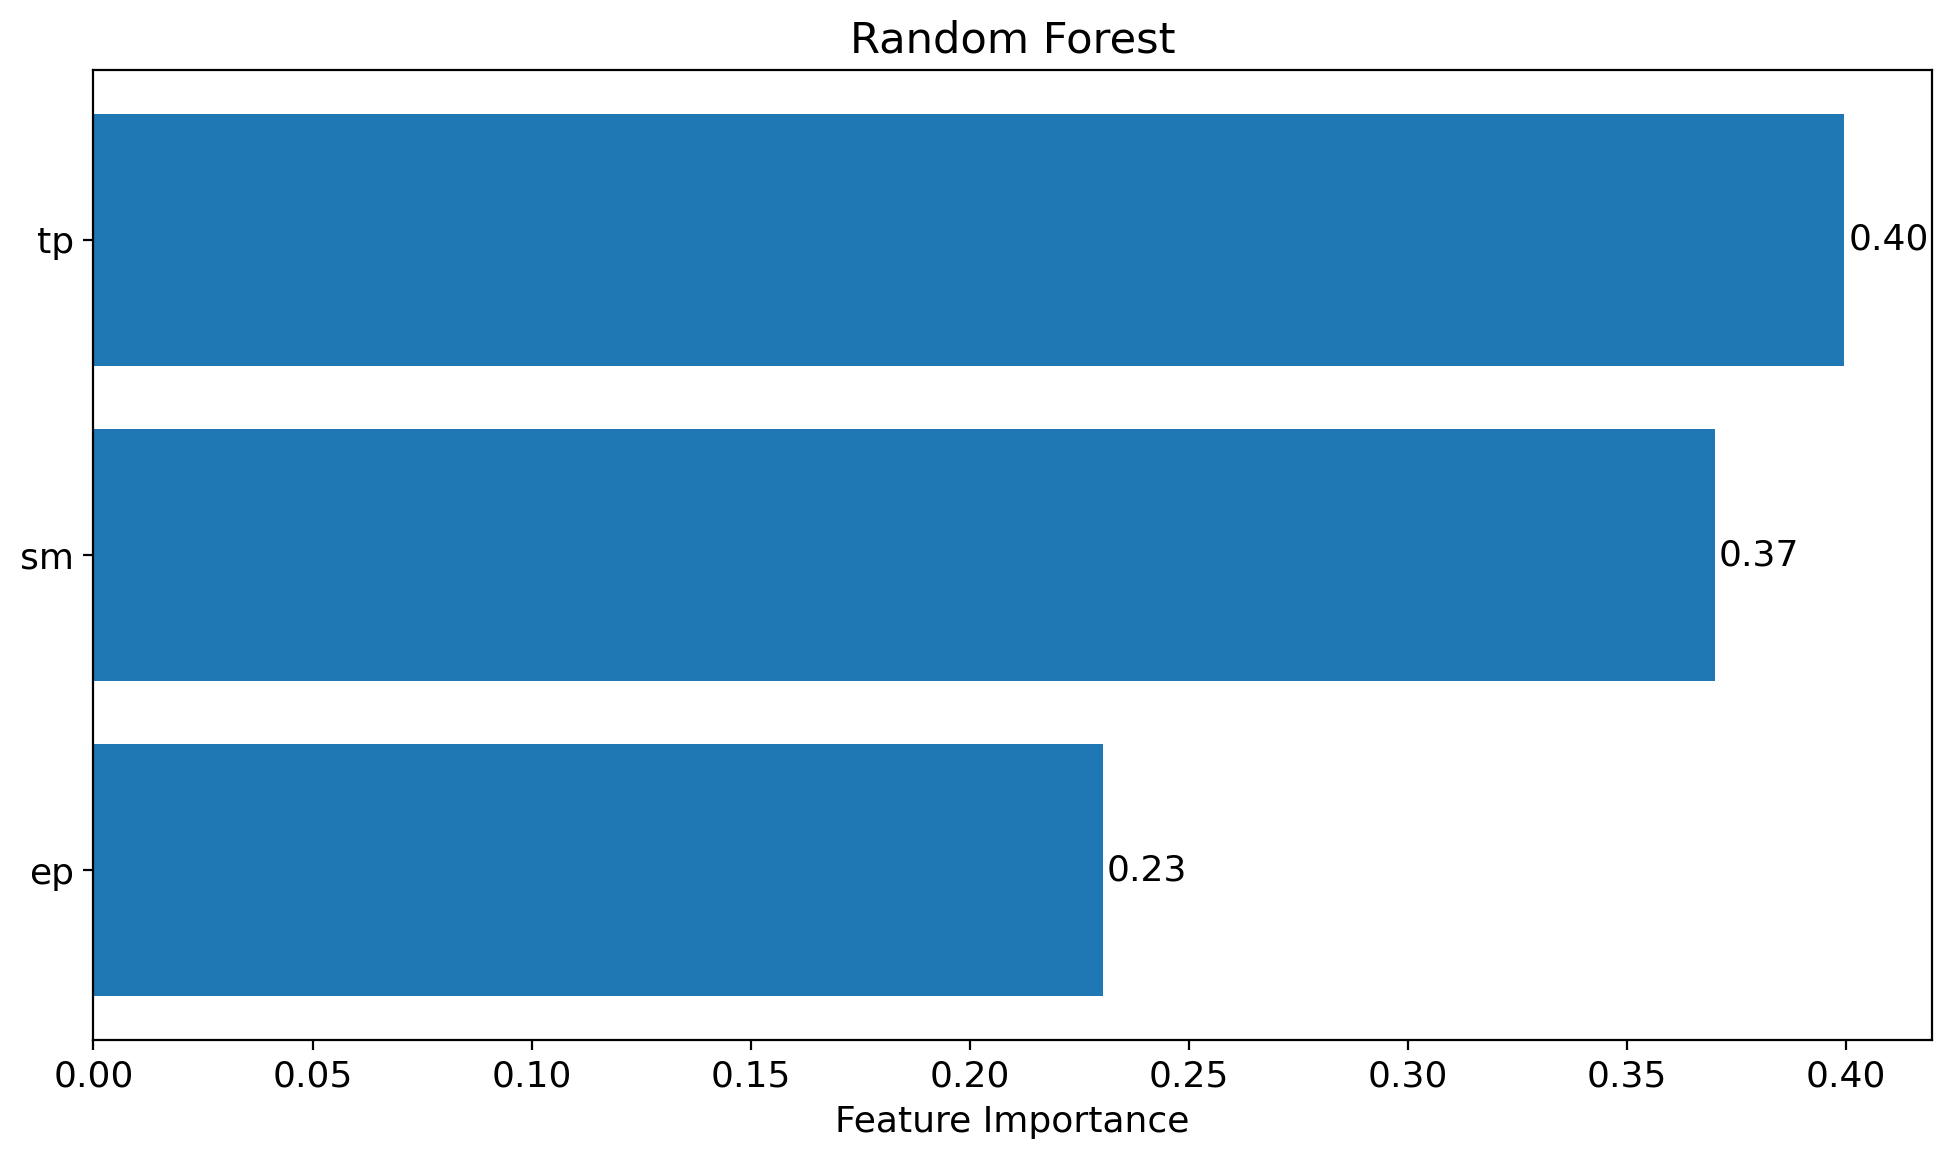

In [32]:
y_train_pred = rf_model.predict(x_train_smart)
y_val_pred = rf_model.predict(x_val_smart)

# evaluation
def calculate_metrics(y_true, y_pred, set_name="train"):
    """calculate"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{set_name} metrics:")
    print(f"  MSE:  {mse:.8f}")
    print(f"  RMSE: {rmse:.8f}")
    print(f"  MAE:  {mae:.8f}")
    print(f"  R²:   {r2:.4f}")
    
    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

train_metrics = calculate_metrics(y_train_smart, y_train_pred, "train")
val_metrics = calculate_metrics(y_val_smart, y_val_pred, "val")

# feature importance
feature_names = ['tp', 'ep', 'sm']  
feature_importance = rf_model.feature_importances_

# feature importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nrank:")
print(importance_df)

# visualization
plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Feature Importance')
plt.title('Random Forest')
plt.gca().invert_yaxis() 

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f}', ha='left', va='center')

plt.tight_layout()
plt.show()

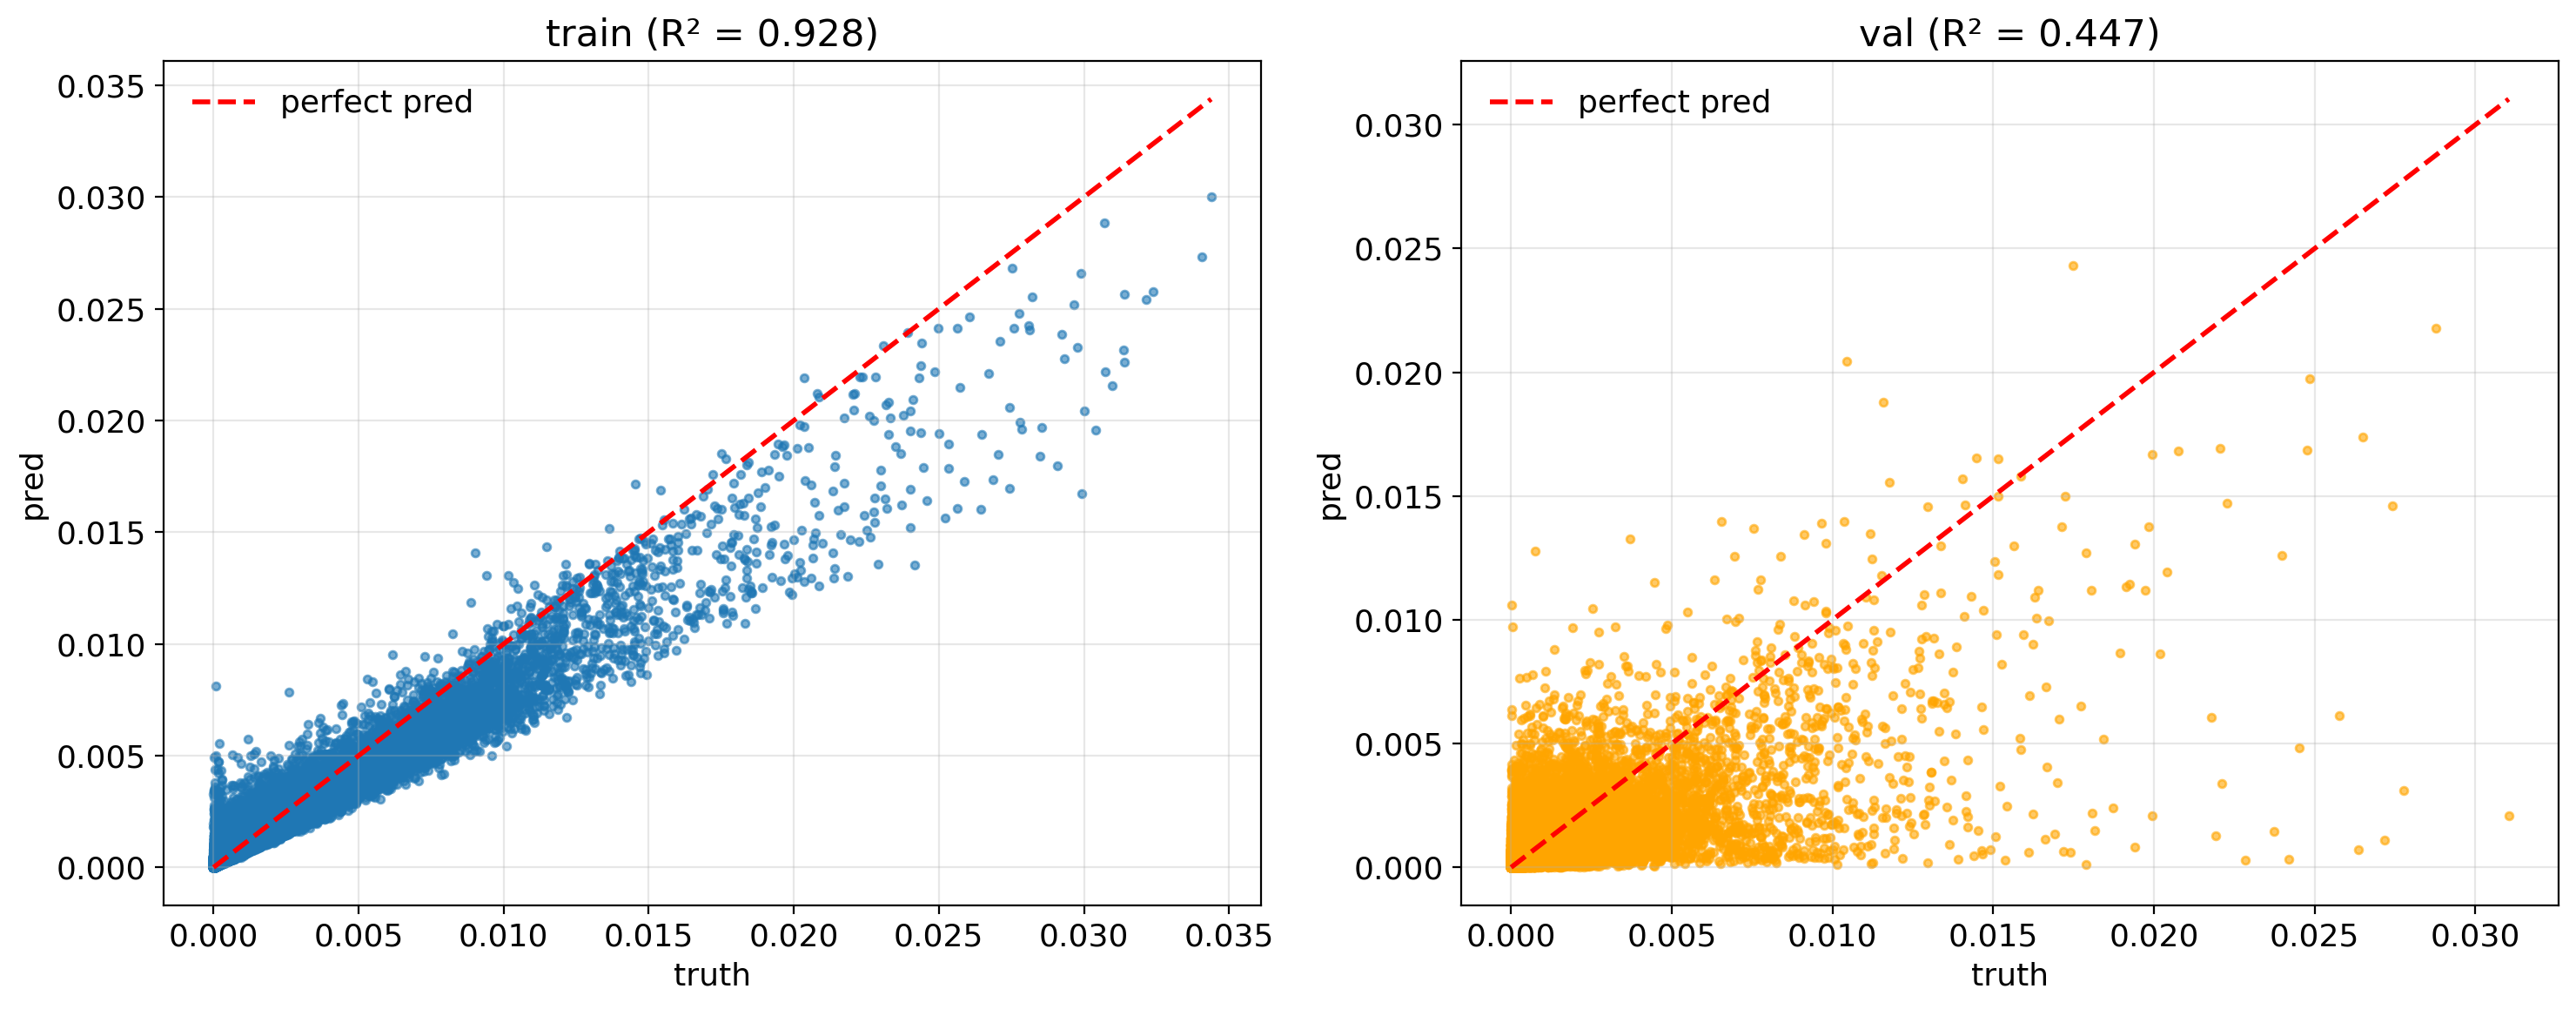

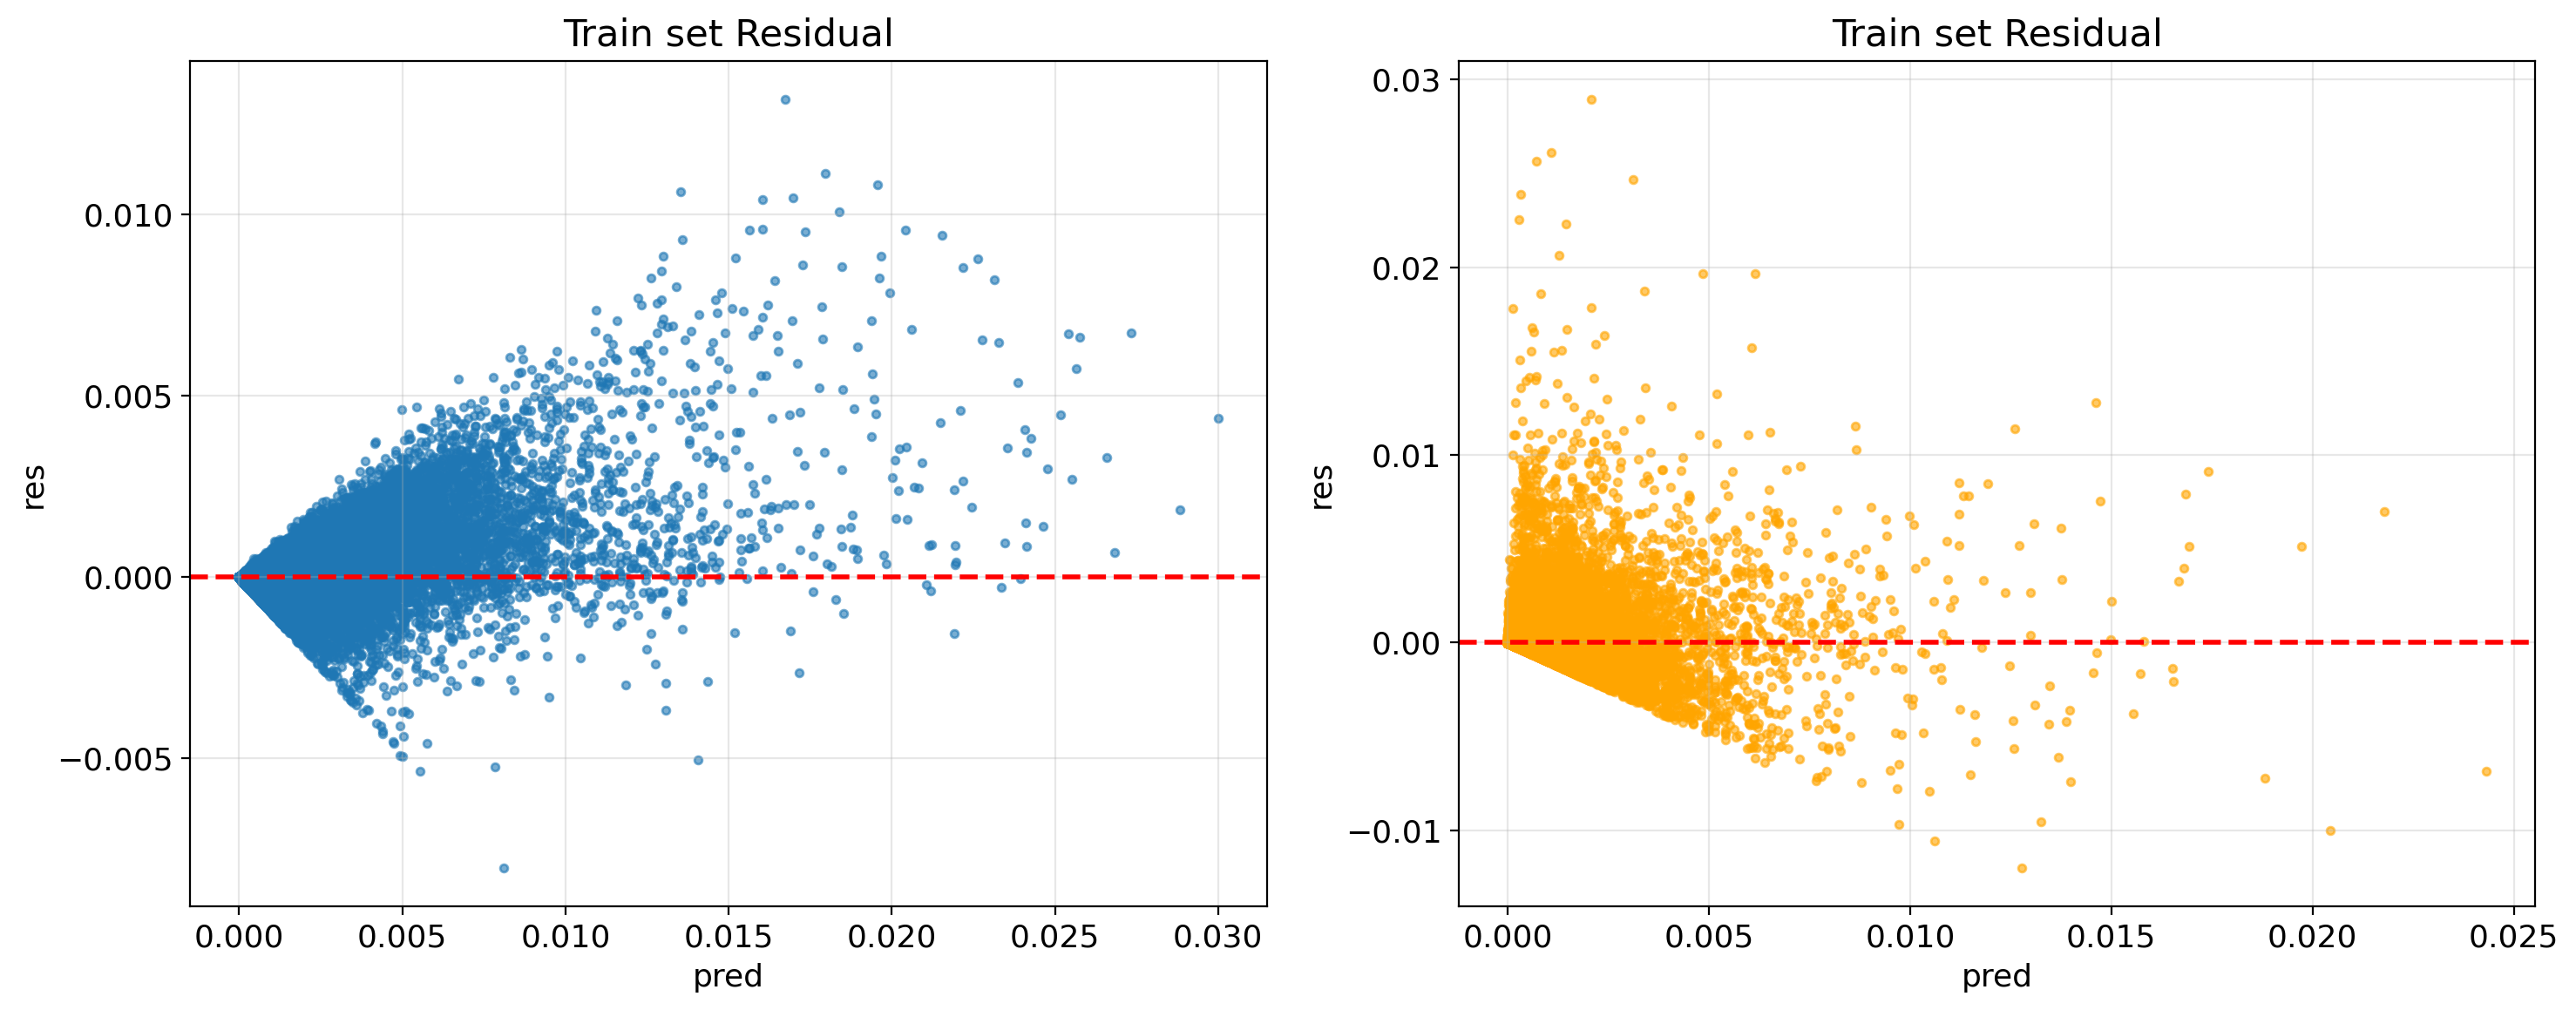

In [33]:
# pred vs truth
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# train scatter plot
axes[0].scatter(y_train_smart, y_train_pred, alpha=0.6, s=10)
axes[0].plot([y_train_smart.min(), y_train_smart.max()], 
            [y_train_smart.min(), y_train_smart.max()], 
            'r--', lw=2, label='perfect pred')
axes[0].set_xlabel('truth')
axes[0].set_ylabel('pred')
axes[0].set_title(f'train (R² = {train_metrics["r2"]:.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# val scatter plot
axes[1].scatter(y_val_smart, y_val_pred, alpha=0.6, s=10, color='orange')
axes[1].plot([y_val_smart.min(), y_val_smart.max()], 
            [y_val_smart.min(), y_val_smart.max()], 
            'r--', lw=2, label='perfect pred')
axes[1].set_xlabel('truth')
axes[1].set_ylabel('pred')
axes[1].set_title(f'val (R² = {val_metrics["r2"]:.3f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# res
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# train
train_residuals = y_train_smart - y_train_pred
axes[0].scatter(y_train_pred, train_residuals, alpha=0.6, s=10)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('pred')
axes[0].set_ylabel('res')
axes[0].set_title('Train set Residual')
axes[0].grid(True, alpha=0.3)

# val
val_residuals = y_val_smart - y_val_pred
axes[1].scatter(y_val_pred, val_residuals, alpha=0.6, s=10, color='orange')
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('pred')
axes[1].set_ylabel('res')
axes[1].set_title('Train set Residual')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [34]:
def manual_tuning_comparison(x_train, y_train, x_val, y_val):
    """
    set different parameters
    """
    # setup
    param_sets = {
        'baseline': {  # default
            'n_estimators': 100,
            'max_depth': None,
            'min_samples_split': 2,
            'min_samples_leaf': 1,
            'max_features': 'sqrt',
            'bootstrap': True,
            'max_samples': None
        },
        'light': {  # light
            'n_estimators': 100,
            'max_depth': 20,
            'min_samples_split': 5,
            'min_samples_leaf': 2,
            'max_features': 'sqrt',
            'bootstrap': True,
            'max_samples': 0.8
        },
        'medium': {  # medium
            'n_estimators': 100,
            'max_depth': 15,
            'min_samples_split': 10,
            'min_samples_leaf': 4,
            'max_features': 'log2',
            'bootstrap': True,
            'max_samples': 0.7
        },
        'strong': {  # strong
            'n_estimators': 150,
            'max_depth': 10,
            'min_samples_split': 20,
            'min_samples_leaf': 8,
            'max_features': 0.5,
            'bootstrap': True,
            'max_samples': 0.6
        }
    }
    
    results = []
    
    for set_name, params in param_sets.items():
        print(f"\n{'='*40}")
        print(f"train: {set_name}")
        print(f"{'='*40}")
        
        print(f"parameter: {params}")
        
        # build & run
        rf = RandomForestRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            max_features=params['max_features'],
            bootstrap=params['bootstrap'],
            max_samples=params['max_samples'],
            random_state=42,
            n_jobs=-1,
            verbose=0
        )
        
        # train
        rf.fit(x_train_smart, y_train_smart)
        
        # pred
        y_train_pred = rf.predict(x_train_smart)
        y_val_pred = rf.predict(x_val_smart)
        
        # metrics
        train_metrics = calculate_metrics(y_train, y_train_pred, "train")
        val_metrics = calculate_metrics(y_val, y_val_pred, "val")
        
        # fp
        feature_importance = rf.feature_importances_
        
        # results
        results.append({
            'set_name': set_name,
            'params': params,
            'train_r2': train_metrics['r2'],
            'val_r2': val_metrics['r2'],
            'r2_gap': train_metrics['r2'] - val_metrics['r2'],
            'train_rmse': train_metrics['rmse'],
            'val_rmse': val_metrics['rmse'],
            'feature_importance': feature_importance
        })
        
        # print
        print(f"overfitting (R² difference): {train_metrics['r2'] - val_metrics['r2']:.4f}")
    
    # table
    print("\n" + "="*60)
    print("comparison")
    print("="*60)
    
    results_df = pd.DataFrame([{
        'model': r['set_name'],
        'Train: R²': r['train_r2'],
        'Test: R²': r['val_r2'],
        'R² difference': r['r2_gap'],
        'Train: RMSE': r['train_rmse'],
        'Val:RMSE': r['val_rmse'],
        'max_depth': r['params']['max_depth'],
        'min_samples_split': r['params']['min_samples_split'],
        'min_samples_leaf': r['params']['min_samples_leaf'],
        'max_features': r['params']['max_features'],
        'max_samples': r['params']['max_samples']
    } for r in results])
    
    print(results_df.to_string(index=False))
    
    # visualization
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. R²
    x = range(len(results))
    width = 0.35
    
    axes[0, 0].bar([i - width/2 for i in x], [r['train_r2'] for r in results], 
                   width, label='train', alpha=0.8)
    axes[0, 0].bar([i + width/2 for i in x], [r['val_r2'] for r in results], 
                   width, label='val', alpha=0.8)
    axes[0, 0].set_xlabel('model')
    axes[0, 0].set_ylabel('R²')
    axes[0, 0].set_title('R² comparison')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels([r['set_name'] for r in results])
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # 2. R² diff
    axes[0, 1].bar(x, [r['r2_gap'] for r in results], alpha=0.7)
    axes[0, 1].set_xlabel('model')
    axes[0, 1].set_ylabel('R² diff (train - val)')
    axes[0, 1].set_title('overfitting')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels([r['set_name'] for r in results])
    axes[0, 1].axhline(y=0.1, color='r', linestyle='--', label='threshold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. RMSE
    axes[1, 0].bar([i - width/2 for i in x], [r['train_rmse'] for r in results], 
                   width, label='train', alpha=0.8)
    axes[1, 0].bar([i + width/2 for i in x], [r['val_rmse'] for r in results], 
                   width, label='val', alpha=0.8)
    axes[1, 0].set_xlabel('model')
    axes[1, 0].set_ylabel('RMSE')
    axes[1, 0].set_title('RMSE comparison')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels([r['set_name'] for r in results])
    axes[1, 0].legend(loc='upper left')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 4. fp
    feature_names = ['tp', 'ep', 'sm']  
    
    # strong
    last_importance = results[-1]['feature_importance']
    sorted_idx = np.argsort(last_importance)[::-1]
    
    axes[1, 1].bar(range(len(feature_names)), last_importance[sorted_idx], alpha=0.7)
    axes[1, 1].set_xlabel('feature')
    axes[1, 1].set_ylabel('importance')
    axes[1, 1].set_title(f"{results[-1]['set_name']} feature importance")
    axes[1, 1].set_xticks(range(len(feature_names)))
    axes[1, 1].set_xticklabels([feature_names[i] for i in sorted_idx])
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return results


train: baseline
parameter: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': None}

train metrics:
  MSE:  0.00000008
  RMSE: 0.00029022
  MAE:  0.00009880
  R²:   0.9277

val metrics:
  MSE:  0.00000070
  RMSE: 0.00083823
  MAE:  0.00040511
  R²:   0.4470
overfitting (R² difference): 0.4806

train: light
parameter: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True, 'max_samples': 0.8}

train metrics:
  MSE:  0.00000034
  RMSE: 0.00057913
  MAE:  0.00020349
  R²:   0.7119

val metrics:
  MSE:  0.00000069
  RMSE: 0.00083300
  MAE:  0.00041729
  R²:   0.4539
overfitting (R² difference): 0.2580

train: medium
parameter: {'n_estimators': 100, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True, 'max_samples': 0.7}

train metrics:
  MSE:  0.00000049
  RMSE: 0.00069

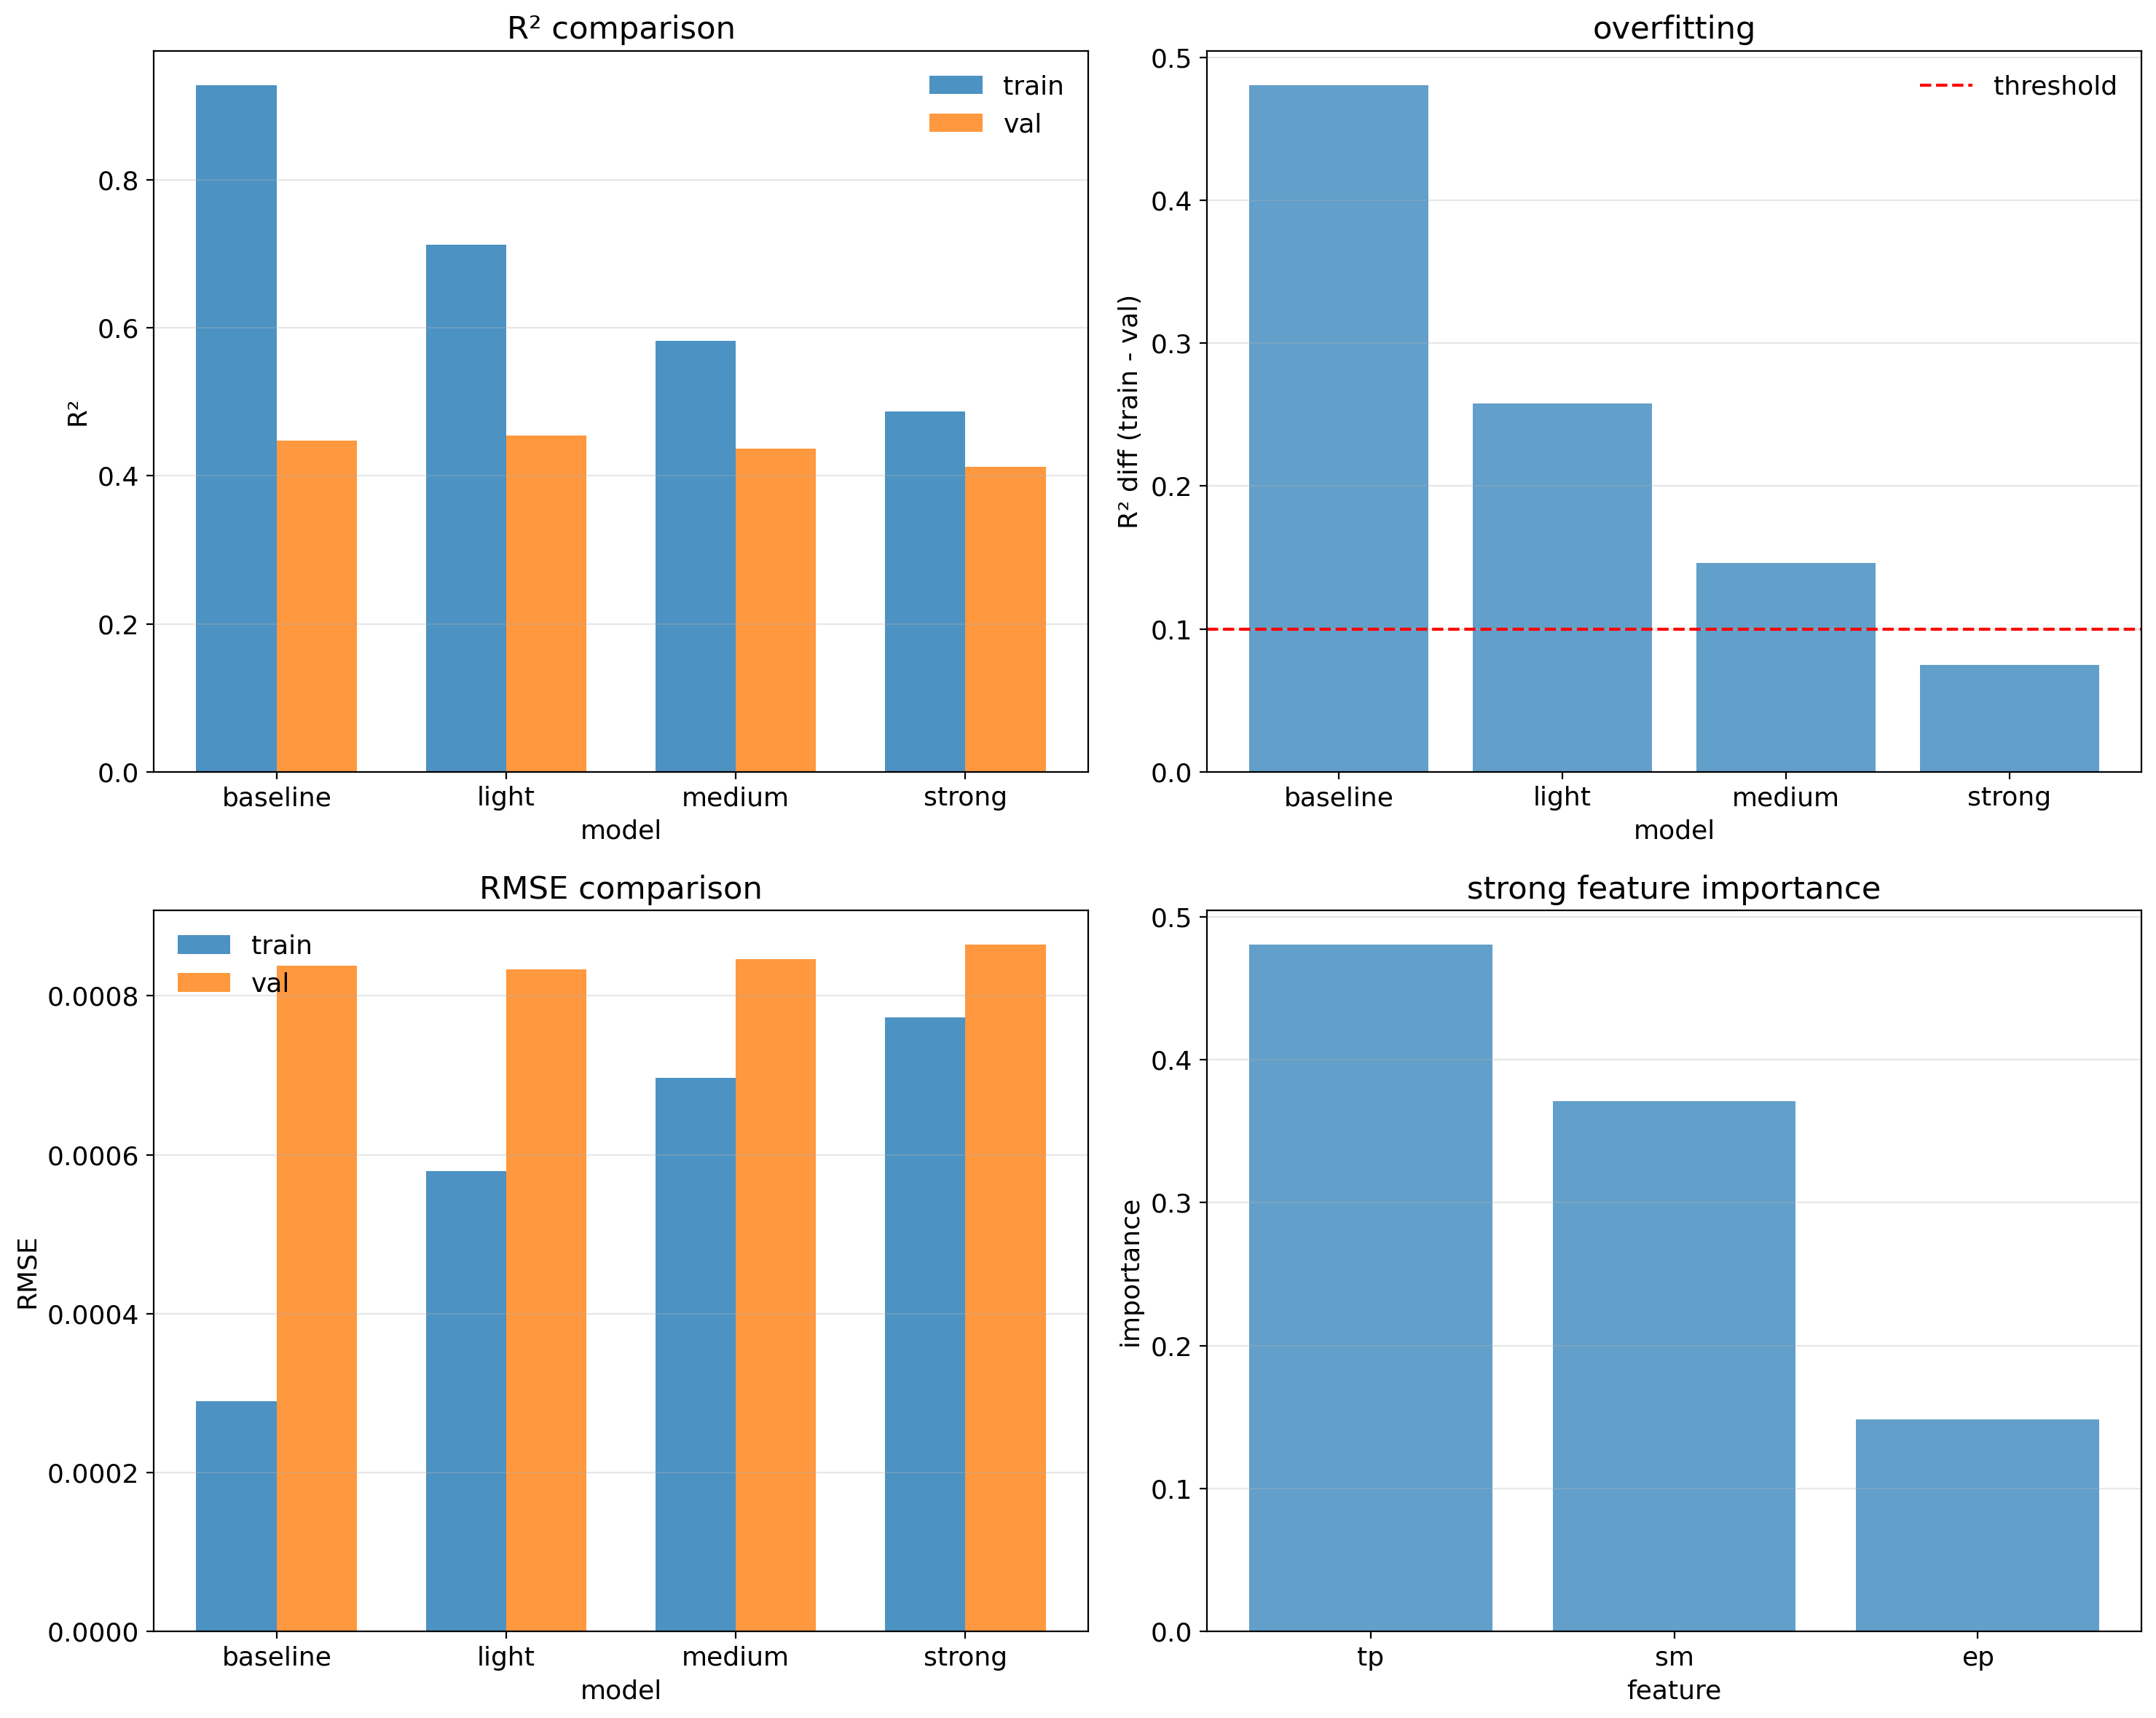


finish！


In [35]:
results = manual_tuning_comparison(
    x_train=x_train_smart,
    y_train=y_train_smart,
    x_val=x_val_smart,
    y_val=y_val_smart
)

print("\nfinish！")

In [117]:
def check_data_preprocessing(x_train, y_train, x_val, y_val):
    """检查数据预处理是否正确"""
    
    print("数据预处理检查:")
    print("-"*40)
    
    # 检查是否标准化
    print("\n1. 是否进行了标准化?")
    print(f"y_train 均值: {np.mean(y_train):.6f}")
    print(f"y_train 标准差: {np.std(y_train):.6f}")
    
    if abs(np.mean(y_train)) < 0.001 and abs(np.std(y_train) - 1.0) < 0.001:
        print("  → 数据已被标准化 (均值≈0, 标准差≈1)")
    elif np.max(y_train) < 1.0:
        print("  → 数据单位是米，数值自然很小")
    else:
        print("  → 数据似乎是原始尺度")
    
    # 检查数据范围
    print("\n2. 数据范围检查:")
    print(f"y_train 范围: [{np.min(y_train):.6f}, {np.max(y_train):.6f}] m")
    print(f"换算为毫米: [{np.min(y_train)*1000:.2f}, {np.max(y_train)*1000:.2f}] mm")
    
    # 检查特征相关性
    print("\n3. 特征-目标相关性检查:")
    feature_names = ['tp', 'ep', 'sm']
    
    for i, name in enumerate(feature_names):
        if i < x_train.shape[1]:
            # 计算相关系数
            corr = np.corrcoef(x_train[:, i], y_train)[0, 1]
            print(f"  {name} 与 ro 的相关系数: {corr:.4f}")
    
    # 检查预测值与实际值的尺度
    print("\n4. 预测性能基准检查:")
    # 朴素预测1: 使用均值
    naive_pred_mean = np.mean(y_train) * np.ones_like(y_val)
    naive_r2_mean = r2_score(y_val, naive_pred_mean)
    
    # 朴素预测2: 使用上个月的值 (如果有时间序列结构)
    print(f"  使用均值预测的R²: {naive_r2_mean:.4f}")
    
    if naive_r2_mean > 0.1:
        print("  → 均值预测就有一定预测能力，数据可能有较强季节性")
    else:
        print("  → 均值预测能力弱，说明数据波动大或无明显趋势")

# 运行检查
check_data_preprocessing(x_train_smart, y_train_smart, x_val_smart, y_val_smart)

数据预处理检查:
----------------------------------------

1. 是否进行了标准化?
y_train 均值: 0.000441
y_train 标准差: 0.001079
  → 数据单位是米，数值自然很小

2. 数据范围检查:
y_train 范围: [0.000000, 0.034383] m
换算为毫米: [0.00, 34.38] mm

3. 特征-目标相关性检查:
  tp 与 ro 的相关系数: 0.4940
  ep 与 ro 的相关系数: 0.0883
  sm 与 ro 的相关系数: 0.3035

4. 预测性能基准检查:
  使用均值预测的R²: -0.0016
  → 均值预测能力弱，说明数据波动大或无明显趋势


GRADIENT BOOSTING MODEL TRAINING
Training set shape: (435456, 3)
Validation set shape: (108864, 3)

Starting Gradient Boosting training...
Parameters: learning_rate=0.1, n_estimators=100, max_depth=3
      Iter       Train Loss   Remaining Time 
         1           0.0000           42.20s
         2           0.0000           41.30s
         3           0.0000           41.28s
         4           0.0000           40.95s
         5           0.0000           40.73s
         6           0.0000           40.12s
         7           0.0000           39.80s
         8           0.0000           39.28s
         9           0.0000           38.87s
        10           0.0000           38.33s
        20           0.0000           33.75s
        30           0.0000           29.55s
        40           0.0000           25.27s
        50           0.0000           21.01s
        60           0.0000           16.78s
        70           0.0000           12.54s
        80           0.0000       

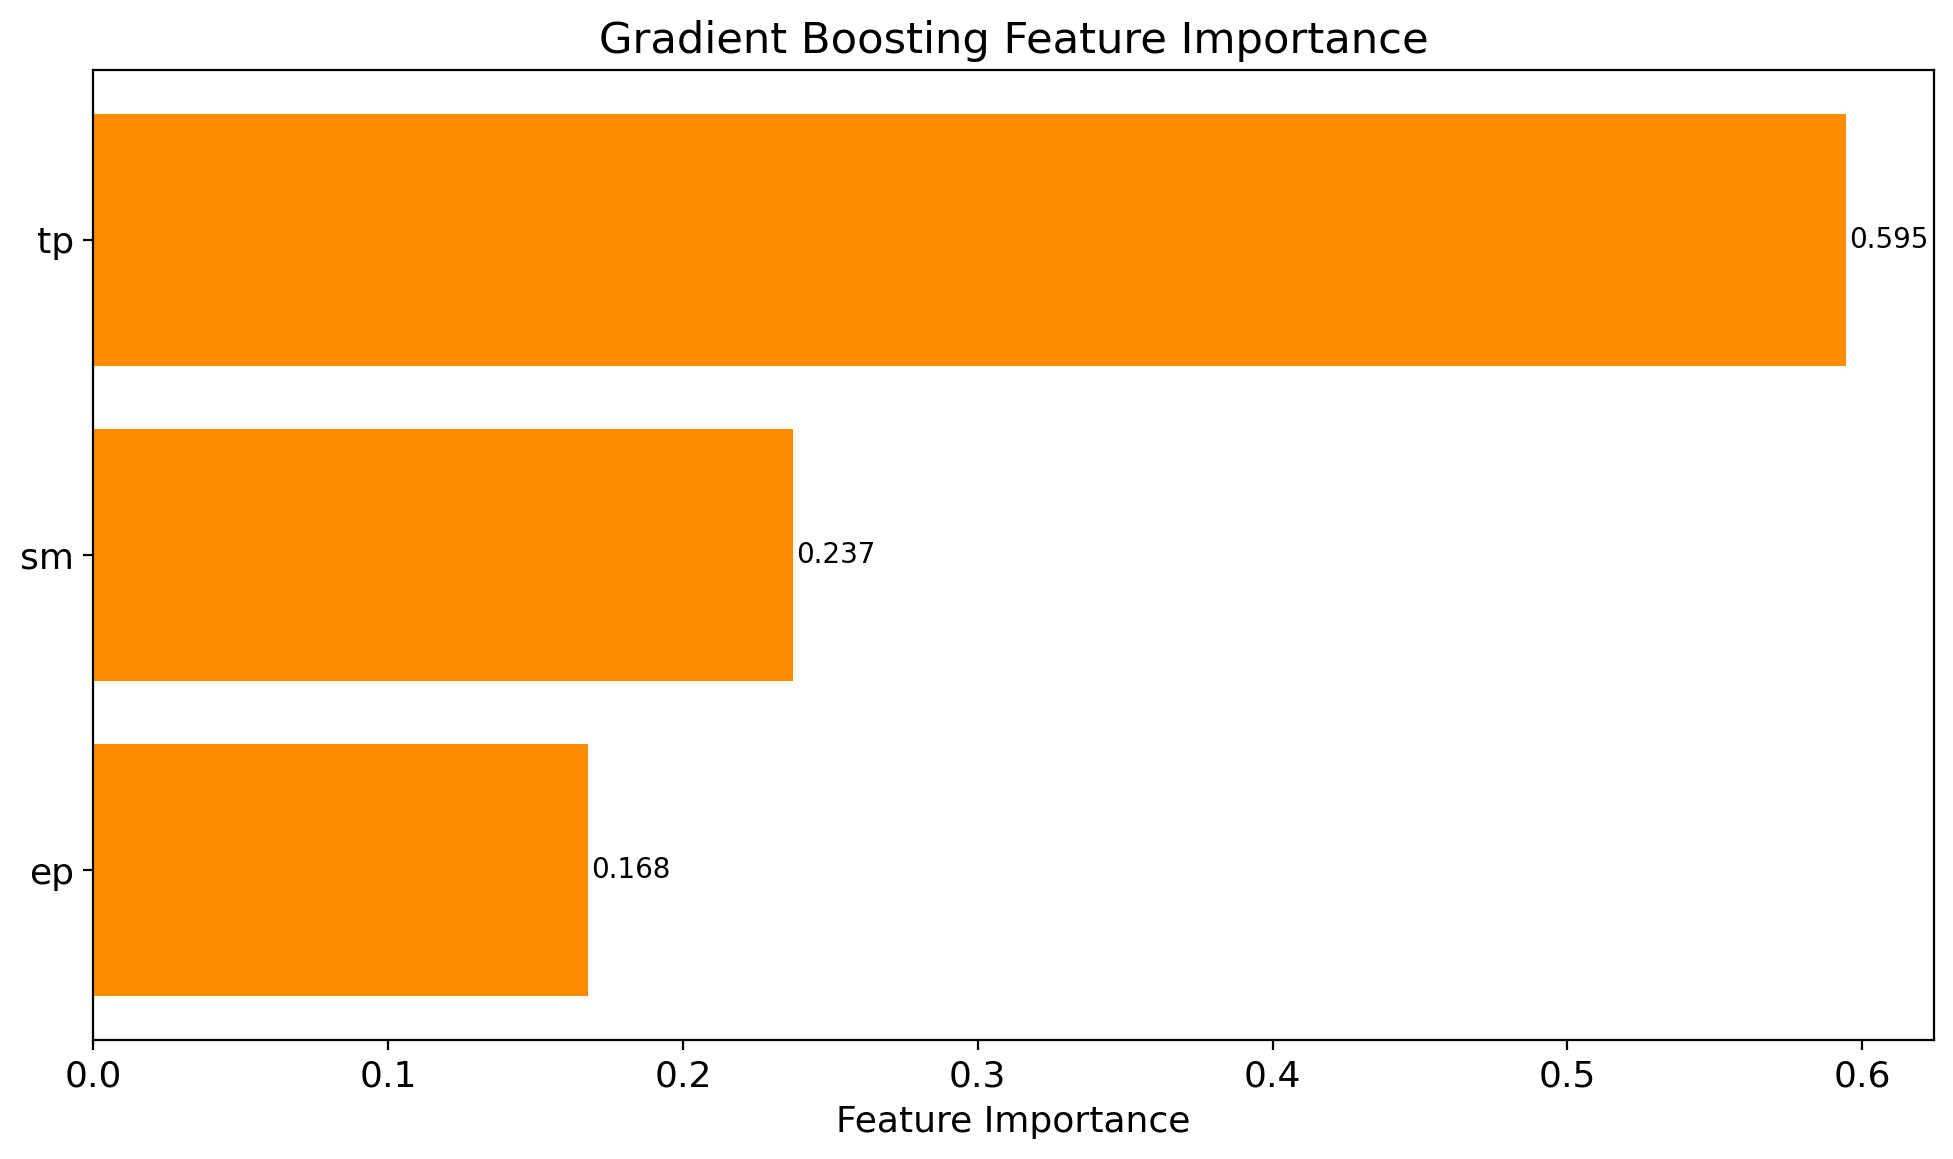

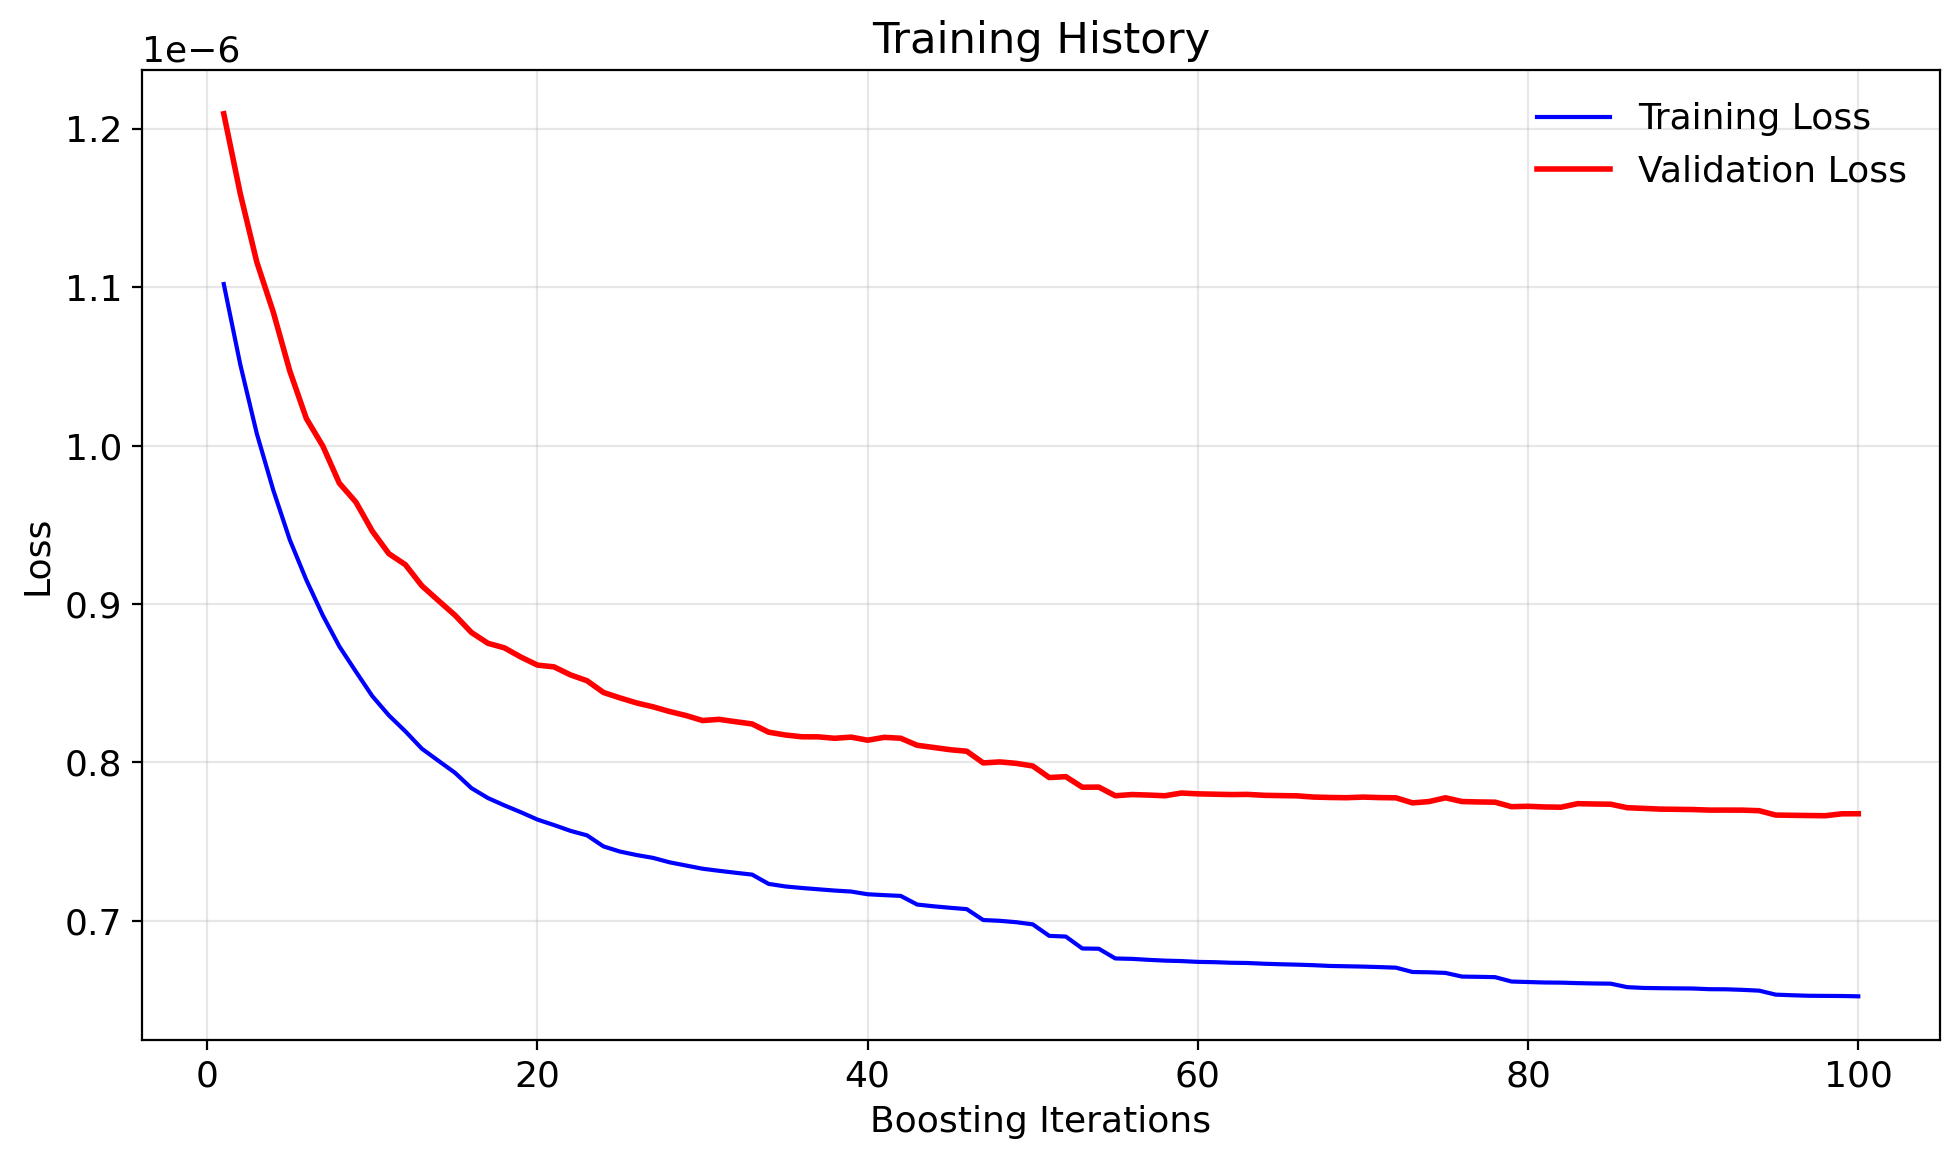

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Gradient Boosting模型训练和评估
def train_gradient_boosting(x_train, y_train, x_val, y_val, learning_rate=0.1, n_estimators=100, max_depth=3):
    """
    训练Gradient Boosting模型并进行评估
    """
    print("="*60)
    print("GRADIENT BOOSTING MODEL TRAINING")
    print("="*60)
    
    print(f"Training set shape: {x_train.shape}")
    print(f"Validation set shape: {x_val.shape}")
    
    # 初始化Gradient Boosting模型
    gb_model = GradientBoostingRegressor(
        n_estimators=n_estimators,      # 树的数量
        learning_rate=learning_rate,    # 学习率
        max_depth=max_depth,            # 树的最大深度
        min_samples_split=2,            # 分裂内部节点所需的最小样本数
        min_samples_leaf=1,             # 叶节点所需的最小样本数
        subsample=1.0,                  # 子采样比例
        max_features=None,              # 每个分裂考虑的特征数
        alpha=0.9,                      # 分位数损失的分位数（用于Huber和分位数损失）
        criterion='friedman_mse',       # 分裂标准
        min_impurity_decrease=0.0,      # 分裂所需的最小不纯度减少
        random_state=42,                # 随机种子
        verbose=1                       # 显示训练进度
    )
    
    print("\nStarting Gradient Boosting training...")
    print(f"Parameters: learning_rate={learning_rate}, n_estimators={n_estimators}, max_depth={max_depth}")
    
    # 训练模型
    gb_model.fit(x_train, y_train)
    print("Gradient Boosting training complete!")
    
    # 预测
    y_train_pred = gb_model.predict(x_train)
    y_val_pred = gb_model.predict(x_val)
    
    # 计算评估指标
    def calculate_metrics(y_true, y_pred, set_name="train"):
        """计算评估指标"""
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        
        print(f"\n{set_name} metrics:")
        print(f"  MSE:  {mse:.8f}")
        print(f"  RMSE: {rmse:.8f}")
        print(f"  MAE:  {mae:.8f}")
        print(f"  R²:   {r2:.4f}")
        
        return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}
    
    train_metrics = calculate_metrics(y_train, y_train_pred, "train")
    val_metrics = calculate_metrics(y_val, y_val_pred, "val")
    
    # 计算过拟合程度
    overfitting_gap = train_metrics['r2'] - val_metrics['r2']
    print(f"\nOverfitting (R² gap): {overfitting_gap:.4f}")
    
    # 特征重要性
    feature_names = ['tp', 'ep', 'sm']
    feature_importance = gb_model.feature_importances_
    
    # 创建特征重要性DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance Ranking:")
    print(importance_df)
    
    # 可视化特征重要性
    plt.figure(figsize=(10, 6))
    bars = plt.barh(importance_df['feature'], importance_df['importance'], color='darkorange')
    plt.xlabel('Feature Importance')
    plt.title('Gradient Boosting Feature Importance')
    plt.gca().invert_yaxis()  # 最重要的特征在最上面
    
    # 在条形上添加数值
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                 f'{width:.3f}', ha='left', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 可视化训练过程（损失下降曲线）
    train_score = gb_model.train_score_  # 每个提升阶段的训练损失
    val_loss = []
    for y_val_pred_stage in gb_model.staged_predict(x_val):
        stage_loss = mean_squared_error(y_val, y_val_pred_stage)
        val_loss.append(stage_loss)
    
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(train_score)) + 1, train_score, 'b-', label='Training Loss')
    plt.plot(np.arange(len(train_score)) + 1, val_loss, 'r-', linewidth=2, label='Validation Loss')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return gb_model, train_metrics, val_metrics, importance_df

# 运行Gradient Boosting
gb_model, train_metrics, val_metrics, importance_df = train_gradient_boosting(
    x_train_smart, y_train_smart, x_val_smart, y_val_smart,
    learning_rate=0.1,  # 学习率
    n_estimators=100,   # 树的数量
    max_depth=3         # 树的最大深度
)

OPTIMIZED GRADIENT BOOSTING MODEL COMPARISON

Training: GB_Fast
Parameters: {'name': 'GB_Fast', 'learning_rate': 0.05, 'n_estimators': 50, 'max_depth': 3, 'subsample': 0.8}
  Train R²: 0.3586
  Val R²:   0.3352
  R² Gap:   0.0234

Training: GB_Standard
Parameters: {'name': 'GB_Standard', 'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'subsample': 1.0}
  Train R²: 0.4396
  Val R²:   0.3959
  R² Gap:   0.0437

Training: GB_Deep
Parameters: {'name': 'GB_Deep', 'learning_rate': 0.05, 'n_estimators': 200, 'max_depth': 5, 'subsample': 0.9}
  Train R²: 0.5032
  Val R²:   0.4108
  R² Gap:   0.0924

Training: GB_Conservative
Parameters: {'name': 'GB_Conservative', 'learning_rate': 0.01, 'n_estimators': 500, 'max_depth': 3, 'subsample': 0.7}
  Train R²: 0.4014
  Val R²:   0.3745
  R² Gap:   0.0269

MODEL COMPARISON RESULTS
     model_name  train_r2   val_r2   r2_gap  train_rmse  val_rmse
        GB_Fast  0.358555 0.335172 0.023383    0.000864  0.000919
    GB_Standard  0.439610 0.395

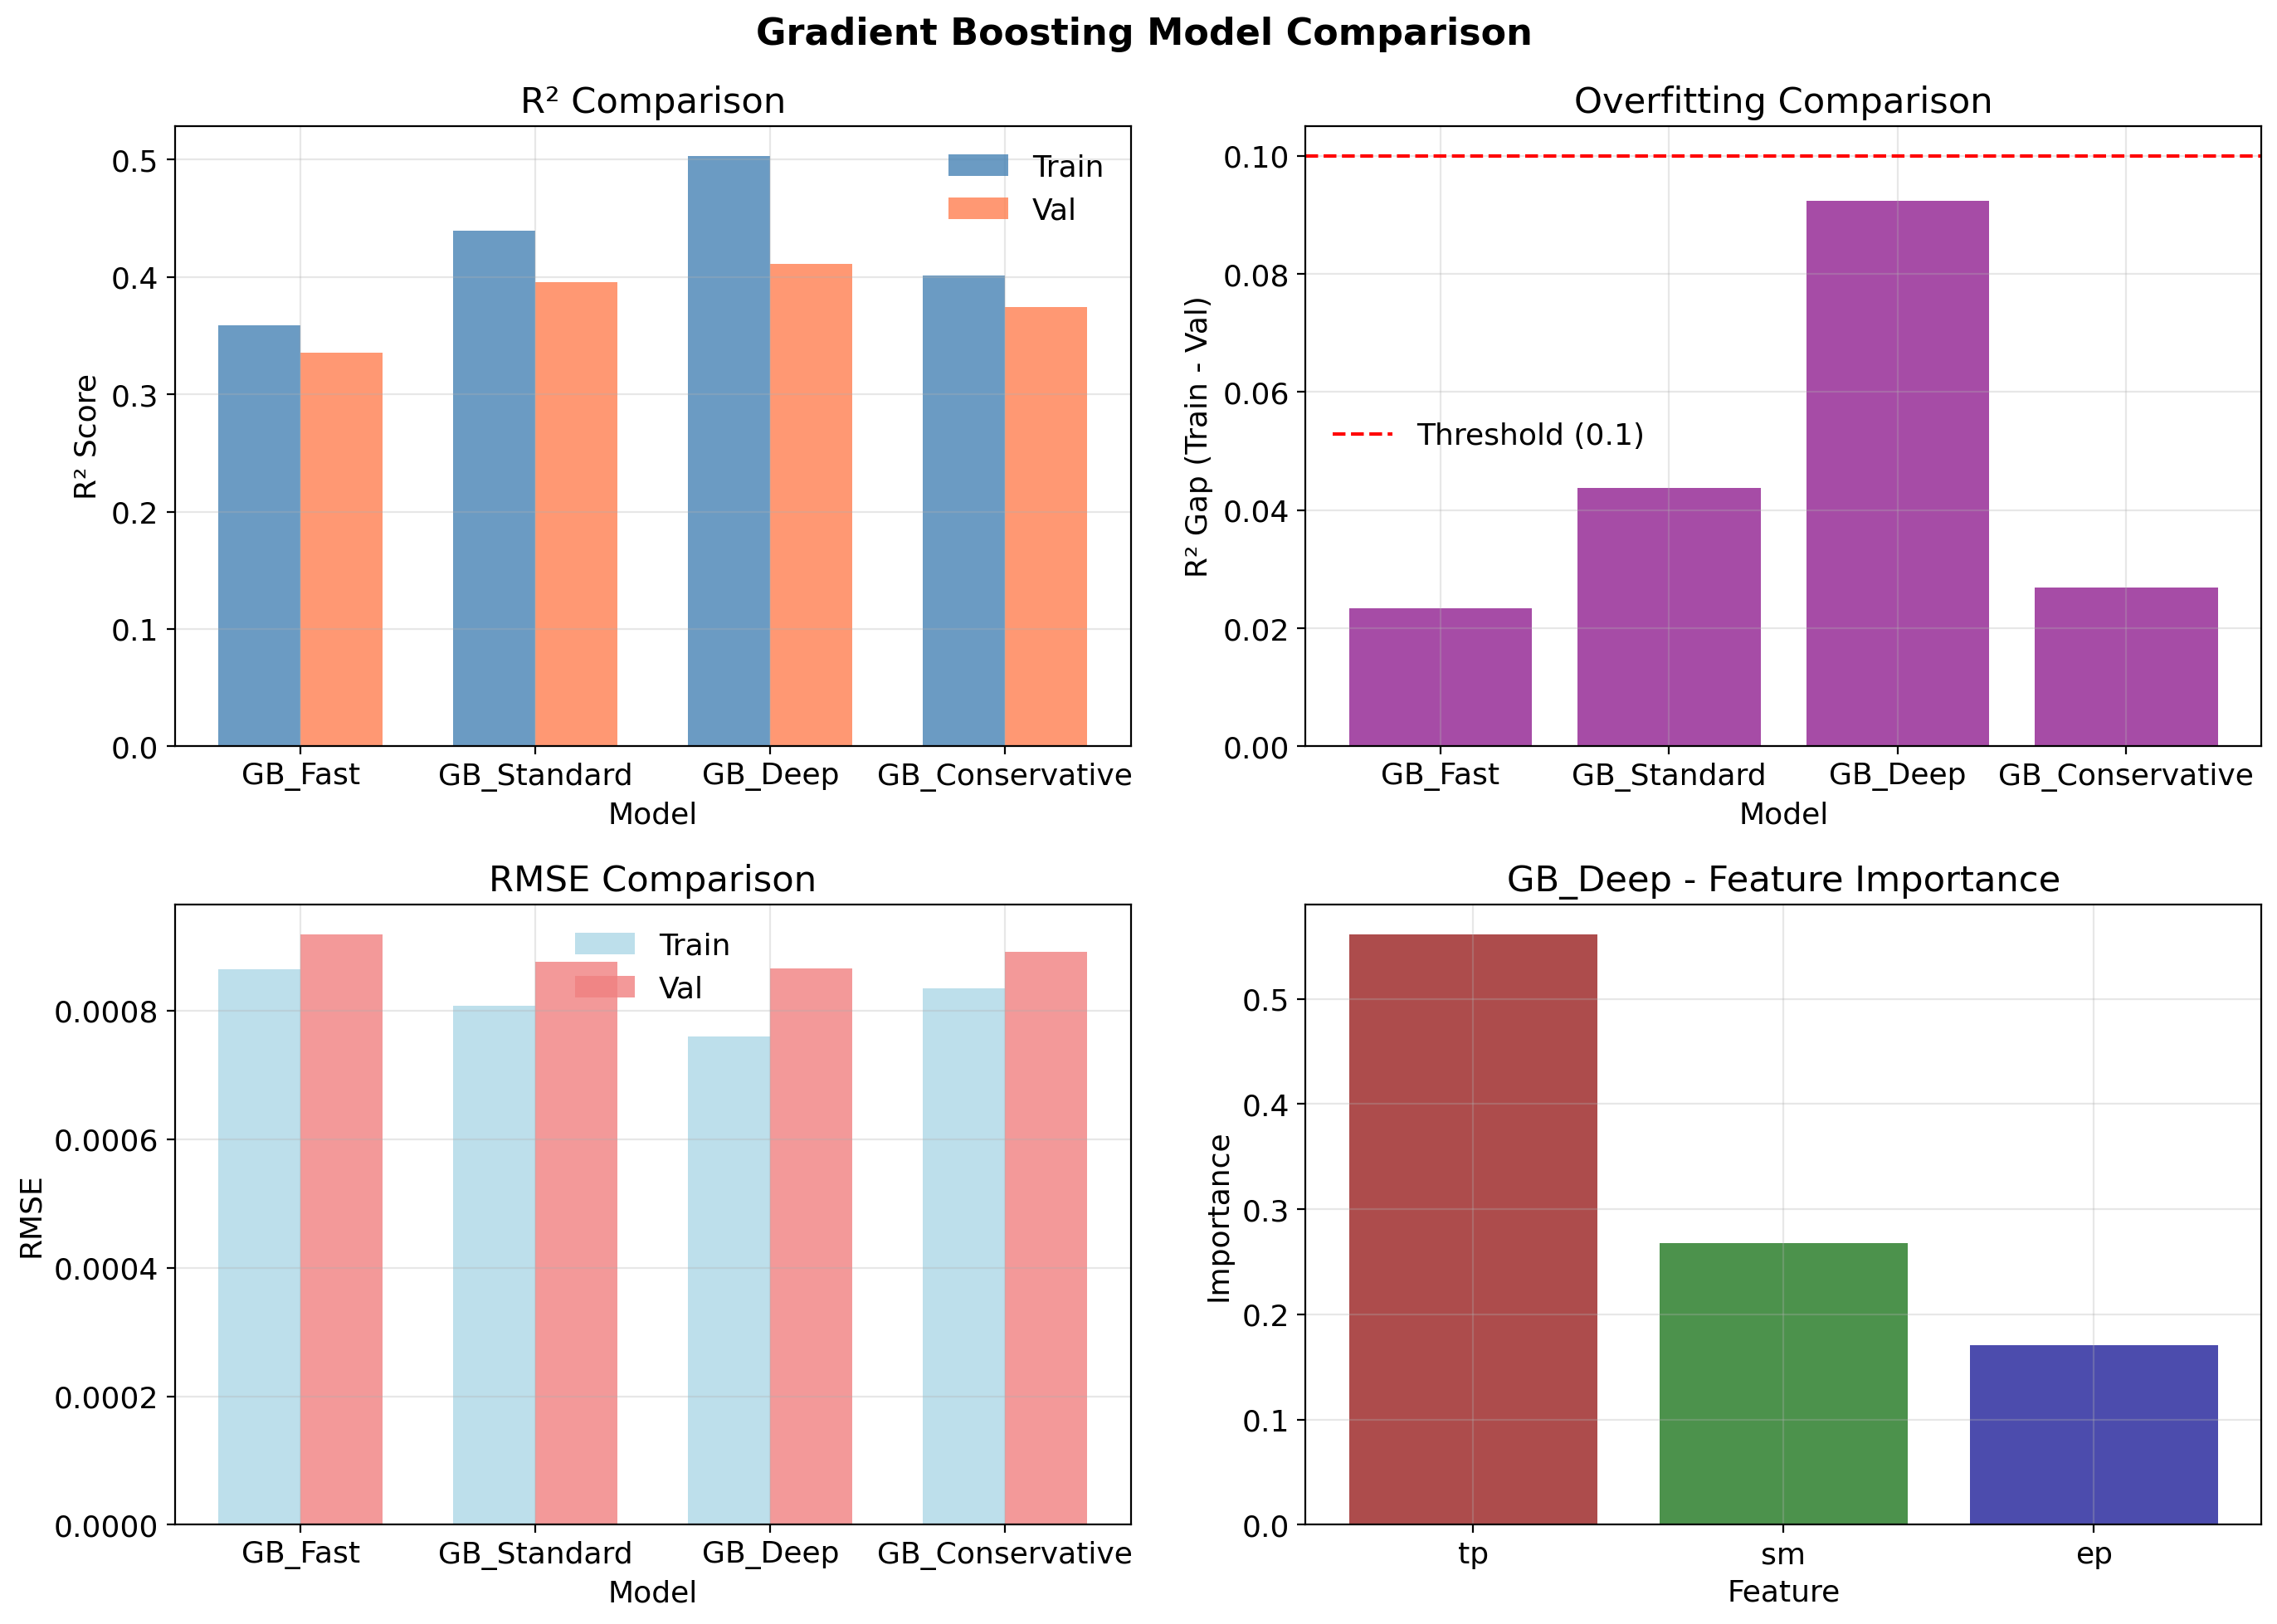

In [40]:
def train_optimized_gradient_boosting(x_train, y_train, x_val, y_val):
    """
    使用不同参数组合的Gradient Boosting，寻找最优配置
    """
    print("="*60)
    print("OPTIMIZED GRADIENT BOOSTING MODEL COMPARISON")
    print("="*60)
    
    # 定义不同的参数组合
    param_configs = [
        {
            'name': 'GB_Fast',
            'learning_rate': 0.05,
            'n_estimators': 50,
            'max_depth': 3,
            'subsample': 0.8
        },
        {
            'name': 'GB_Standard',
            'learning_rate': 0.1,
            'n_estimators': 100,
            'max_depth': 3,
            'subsample': 1.0
        },
        {
            'name': 'GB_Deep',
            'learning_rate': 0.05,
            'n_estimators': 200,
            'max_depth': 5,
            'subsample': 0.9
        },
        {
            'name': 'GB_Conservative',
            'learning_rate': 0.01,
            'n_estimators': 500,
            'max_depth': 3,
            'subsample': 0.7
        }
    ]
    
    results = []
    
    for config in param_configs:
        print(f"\n{'='*40}")
        print(f"Training: {config['name']}")
        print(f"{'='*40}")
        
        print(f"Parameters: {config}")
        
        # 训练模型
        gb = GradientBoostingRegressor(
            learning_rate=config['learning_rate'],
            n_estimators=config['n_estimators'],
            max_depth=config['max_depth'],
            subsample=config['subsample'],
            random_state=42,
            verbose=0
        )
        
        gb.fit(x_train, y_train)
        
        # 预测
        y_train_pred = gb.predict(x_train)
        y_val_pred = gb.predict(x_val)
        
        # 计算指标
        train_r2 = r2_score(y_train, y_train_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        
        # 存储结果
        results.append({
            'model_name': config['name'],
            'train_r2': train_r2,
            'val_r2': val_r2,
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            'r2_gap': train_r2 - val_r2,
            'learning_rate': config['learning_rate'],
            'n_estimators': config['n_estimators'],
            'max_depth': config['max_depth'],
            'subsample': config['subsample']
        })
        
        print(f"  Train R²: {train_r2:.4f}")
        print(f"  Val R²:   {val_r2:.4f}")
        print(f"  R² Gap:   {train_r2 - val_r2:.4f}")
    
    # 创建结果对比表格
    results_df = pd.DataFrame(results)
    print("\n" + "="*60)
    print("MODEL COMPARISON RESULTS")
    print("="*60)
    print(results_df[['model_name', 'train_r2', 'val_r2', 'r2_gap', 'train_rmse', 'val_rmse']].to_string(index=False))
    
    # 可视化对比
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. R²对比
    x = range(len(results))
    width = 0.35
    
    axes[0, 0].bar([i - width/2 for i in x], [r['train_r2'] for r in results], 
                   width, label='Train', alpha=0.8, color='steelblue')
    axes[0, 0].bar([i + width/2 for i in x], [r['val_r2'] for r in results], 
                   width, label='Val', alpha=0.8, color='coral')
    axes[0, 0].set_xlabel('Model')
    axes[0, 0].set_ylabel('R² Score')
    axes[0, 0].set_title('R² Comparison')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels([r['model_name'] for r in results])
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. R²差距
    axes[0, 1].bar(x, [r['r2_gap'] for r in results], alpha=0.7, color='purple')
    axes[0, 1].set_xlabel('Model')
    axes[0, 1].set_ylabel('R² Gap (Train - Val)')
    axes[0, 1].set_title('Overfitting Comparison')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels([r['model_name'] for r in results])
    axes[0, 1].axhline(y=0.1, color='r', linestyle='--', label='Threshold (0.1)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. RMSE对比
    axes[1, 0].bar([i - width/2 for i in x], [r['train_rmse'] for r in results], 
                   width, label='Train', alpha=0.8, color='lightblue')
    axes[1, 0].bar([i + width/2 for i in x], [r['val_rmse'] for r in results], 
                   width, label='Val', alpha=0.8, color='lightcoral')
    axes[1, 0].set_xlabel('Model')
    axes[1, 0].set_ylabel('RMSE')
    axes[1, 0].set_title('RMSE Comparison')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels([r['model_name'] for r in results])
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. 最佳模型的特征重要性
    best_result = max(results, key=lambda x: x['val_r2'])
    
    # 重新训练最佳模型以获取特征重要性
    best_gb = GradientBoostingRegressor(
        learning_rate=best_result['learning_rate'],
        n_estimators=best_result['n_estimators'],
        max_depth=best_result['max_depth'],
        subsample=best_result['subsample'],
        random_state=42
    )
    best_gb.fit(x_train, y_train)
    
    feature_names = ['tp', 'ep', 'sm']
    best_importance = best_gb.feature_importances_
    sorted_idx = np.argsort(best_importance)[::-1]
    
    axes[1, 1].bar(range(len(feature_names)), best_importance[sorted_idx], 
                   alpha=0.7, color=['darkred', 'darkgreen', 'darkblue'])
    axes[1, 1].set_xlabel('Feature')
    axes[1, 1].set_ylabel('Importance')
    axes[1, 1].set_title(f"{best_result['model_name']} - Feature Importance")
    axes[1, 1].set_xticks(range(len(feature_names)))
    axes[1, 1].set_xticklabels([feature_names[i] for i in sorted_idx])
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.suptitle('Gradient Boosting Model Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return results_df, best_result

# 运行优化版Gradient Boosting
results_df, best_result = train_optimized_gradient_boosting(
    x_train_smart, y_train_smart, x_val_smart, y_val_smart
)